# Comparing ConFair to OMN, KAM, and CAP

In [1]:
import warnings
import sys
sys.path.append('../')
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
from PrepareData import read_json, make_folder

## Read results from disc

In [3]:
repo_dir = sys.path[0].replace('notebooks', '')
eval_path=repo_dir+ 'eval/'

In [4]:
# for visualization change the values to be consistent with the order that higher is better
def normalize_fairness_measures(x):
    if 'Diff' in x.iloc[0]: # difference change to 1-abs(x)
        return 1-abs(x.iloc[1])
    
    elif x.iloc[0] == 'DI':
        if x.iloc[1] > 1:
            return min(x.iloc[1], 1/x.iloc[1])
        else:
            return x.iloc[1]
    else:# other metrics
        return x.iloc[1]
def add_vis_flag(x):
    if 'Diff' in x.iloc[0]: # difference change to 1-abs(x)
        if x.iloc[0] in ['ERRDiff', 'FNRDiff', 'FPRDiff']: # measures with lower value means better
            if x.iloc[1] > 0: 
                return 0
            else: # G0 has better outcome
                return 1
        else: # for measures like eqdiff, avgoddsdiff with higher value means better
            if x.iloc[1] < 0: 
                return 0
            else: # G0 has better outcome
                return 1
    
    elif x.iloc[0] == 'DI':
        if x.iloc[1] > 1:
            return 1
        else:
            return 0
    else:# other metrics
        return 0


In [5]:
seeds = [1, 12345, 6, 2211, 15, 88, 121, 433, 500, 1121, 50, 583, 5278, 100000, 0xbeef, 0xcafe, 0xdead, 7777, 100, 923]

models = ['LR', 'TR']

datasets = ['meps16', 'lsac', 'ACSP', 'credit', 'ACSE', 'ACSH', 'ACSI']

In [6]:
eval_file = 'confair-eval.csv'

if os.path.exists(eval_path+eval_file):
    eval_df = pd.read_csv(eval_path+eval_file)
    print('Read evaluation results at {}'.format(eval_path+eval_file))
else:
    eval_df = pd.DataFrame()
    for data_name in datasets:
        # assuming the res-X.csv generated by running "exec_confair.zsh"
        cur_eval_df = pd.read_csv('{}res-{}.csv'.format(eval_path, data_name))
        cur_eval_df['norm_value'] = cur_eval_df[['metric', 'value']].apply(lambda x: normalize_fairness_measures(x), axis=1)
        cur_eval_df['norm_flag'] = cur_eval_df[['metric', 'value']].apply(lambda x: add_vis_flag(x), axis=1)

        eval_df = pd.concat([eval_df, cur_eval_df])
    
    eval_df.to_csv(eval_path+eval_file, index=False)
    print('Save evaluation results at {}'.format(eval_path+eval_file))

Read evaluation results at /Users/keyang/Projects/PubRepo/NonInvasiveTool4FairML/eval/confair-eval.csv


In [7]:
eval_df.head()

,data,model,seed,method,group,metric,value,norm_value,norm_flag
0,meps16,LR,1,MCC-MIN,all,AUC,0.739000,0.739000,0
1,meps16,LR,1,MCC-MIN,all,ACC,0.741000,0.741000,0
2,meps16,LR,1,MCC-MIN,all,SR,0.333333,0.333333,0
3,meps16,LR,1,MCC-MIN,all,BalAcc,0.739492,0.739492,0
4,meps16,LR,1,MCC-MIN,G0,AUC,0.742000,0.742000,0


## Draw barplots

In [9]:
def bar_plots(df, output_name, vis_datasets, vis_metric, vis_settings, group_input=None,
              legend_names=None, font_label=26, font_legend=18, 
              color_map = None,
              colors=['#ffffff', '#fffacd', '#3cb371','#20603d', '#0e6670'], bg_color = '#f3f3f3', x_tick_offset=6.3,
              x_ticks=None, y_label=None, x_label=None, legend=True, legend_col=5, save_to_disc=True):
    
    fig, ax = plt.subplots(1, figsize=(10, 4), dpi=200)
    input_df = df.copy()
    bar_mean = []
    bar_std = []
    dash_filling = []
    line_styles = []
    x_bars = []
    ind = 0
    
    for off_i, name in enumerate(vis_datasets):
        vis_df = input_df[(input_df['data']==name) & (input_df['metric']==vis_metric) & (input_df['group']==group_input)].copy()
        for setting_i in vis_settings:
            set_df = vis_df[vis_df['method']==setting_i]
            
            if set_df.shape[0] > 0:
                y_values = np.array(set_df['norm_value'])
                n_reverse = sum(np.array(set_df['norm_flag']))
                if n_reverse > int(len(y_values) * 0.9): # majoirty of cases in which G0 has better outcomes
                    dash_id = 1
                else:
                    dash_id = 0
                
                cur_mean = np.mean(y_values)
                cur_std = np.std(y_values)
                if cur_mean == 0:
                    cur_mean = 0
                    line_styles.append('solid')
                elif vis_metric == 'BalAcc' and cur_std < 0.01 and abs(cur_mean-0.5) < 0.01:
                    line_styles.append('dashed')
                    dash_id = 2
                elif vis_metric in ['DI', 'AvgOddsDiff', 'EQDiff'] and cur_std < 0.01 and abs(1-cur_mean) < 0.0001:
                    line_styles.append('dashed')
                    cur_mean = 0.001
                else:
                    line_styles.append('solid')
                    
                bar_mean.append(cur_mean)
                bar_std.append(cur_std)
            else: # no model is returned
                dash_id = 0
                line_styles.append('dashed')
                bar_mean.append(0)
                bar_std.append(0)
                
            dash_filling.append(dash_id)    
            x_bars.append(ind+off_i*2)
                
            ind += 0.83
    bplot = ax.bar(x_bars, bar_mean, yerr=bar_std)
    
    n_bars = len(vis_settings)
    for idx, patch in enumerate(bplot):
        cur_setting = vis_settings[idx % n_bars]
        face_c = color_map[cur_setting]['face']
        fill_c = color_map[cur_setting]['filling']
        patch.set_facecolor(face_c)
        
        if dash_filling[idx] == 2: # for BalAcc case
            patch.set_hatch('xx')
            patch.set_edgecolor(fill_c)
        elif dash_filling[idx] == 1:
            patch.set_hatch('//')
            patch.set_edgecolor(fill_c)
        else:
            patch.set_edgecolor("black")
        
        patch.set_linestyle(line_styles[idx])
        
    if legend_names:
        legends = legend_names
    else:
        legends = vis_settings
    # add labels for settings 
    for idx, setting_i, color_i, legend_i in zip(range(len(vis_settings)), vis_settings, colors, legends):
        ax.bar(-2, 1, ec='black', fc=color_map[setting_i]['face'], label=legend_i)

    ax.set_facecolor(bg_color)
    ax.yaxis.grid(True)
    plt.xlim([-1, max(x_bars)+1])
    plt.xticks([(x-1)*x_tick_offset+0.8 for x in range(1, len(vis_datasets)+1)])
    if x_ticks:
        locs, labels=plt.xticks();
        plt.xticks(locs, x_ticks, horizontalalignment='center', fontsize=font_label-10, rotation=0);

    plt.ylim([0.0, 1.0])
    plt.yticks(fontsize=font_label);

    if y_label:
        plt.ylabel(y_label, fontsize=font_label)

    if x_label:
        plt.xlabel(x_label, fontsize=font_label)

    if legend:
        plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower center", mode="expand", ncol=legend_col, frameon=False, borderaxespad=0, handlelength=0.9, handletextpad=0.3, fontsize=font_label-7)

    if save_to_disc:
        plt.savefig(output_name, bbox_inches="tight")
#         print('Bar plot is saved at ', output_name)
#         plt.close()

In [10]:
plot_path = repo_dir+ 'intermediate/plots/baseline/'
make_folder(plot_path)

## Comparing ConFair to KAM-CAL

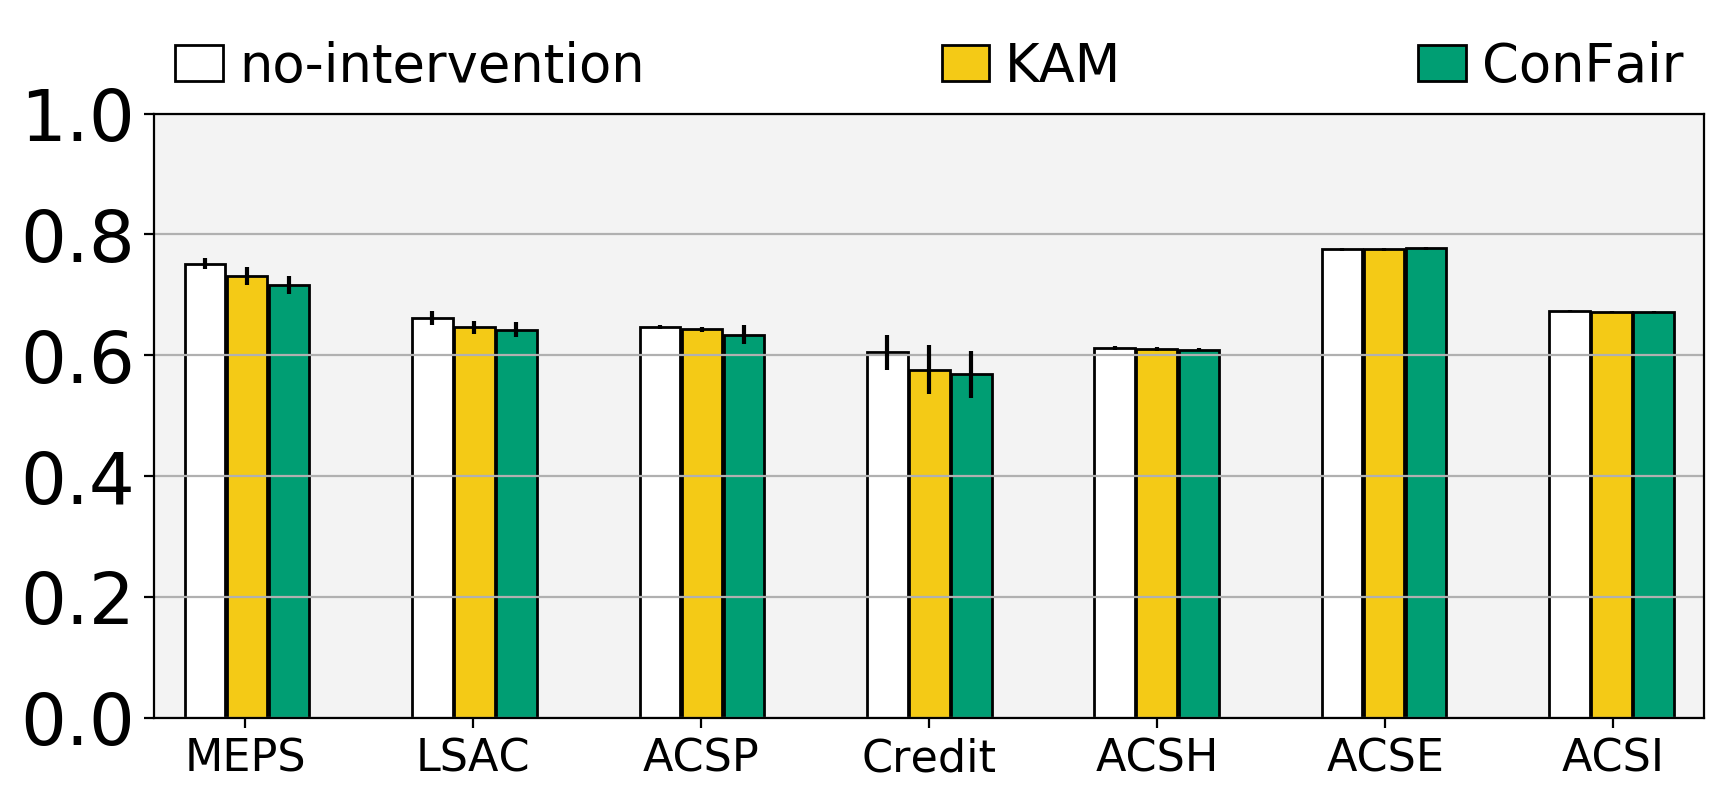

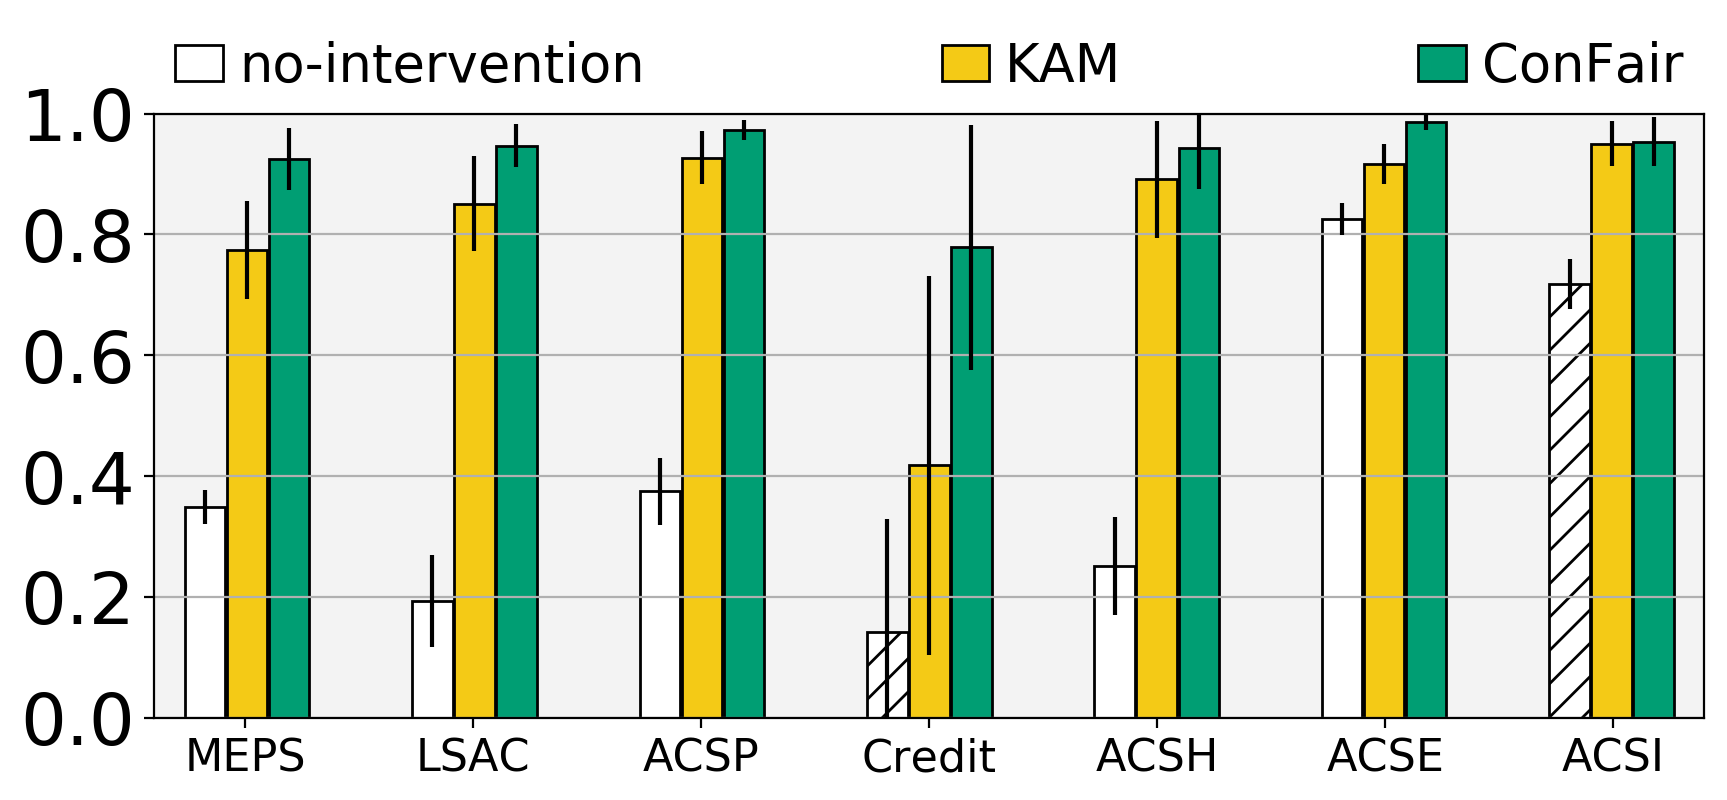

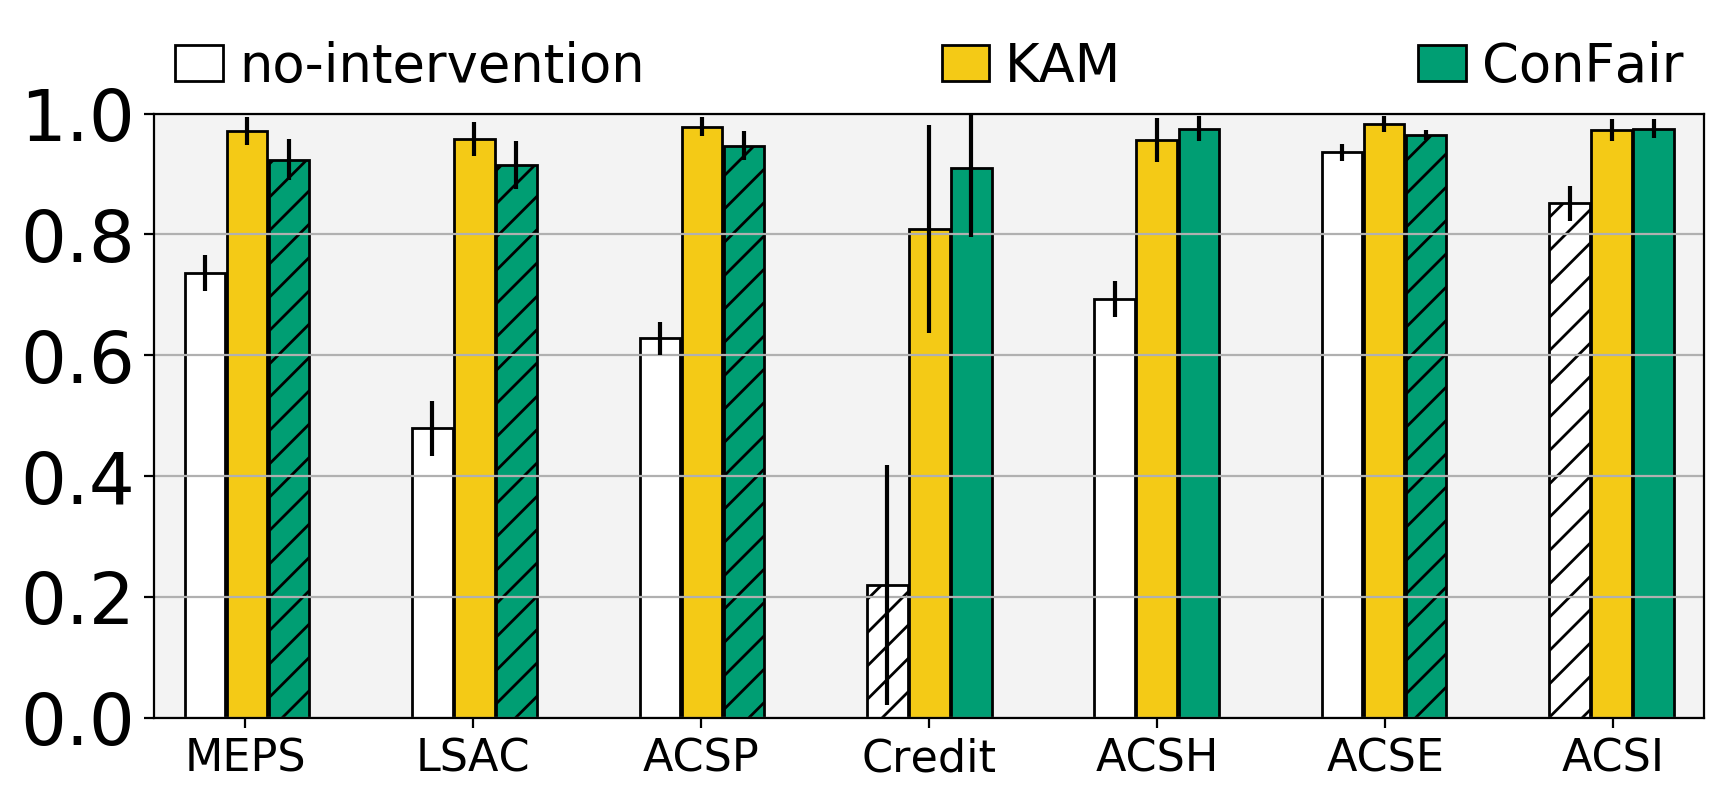

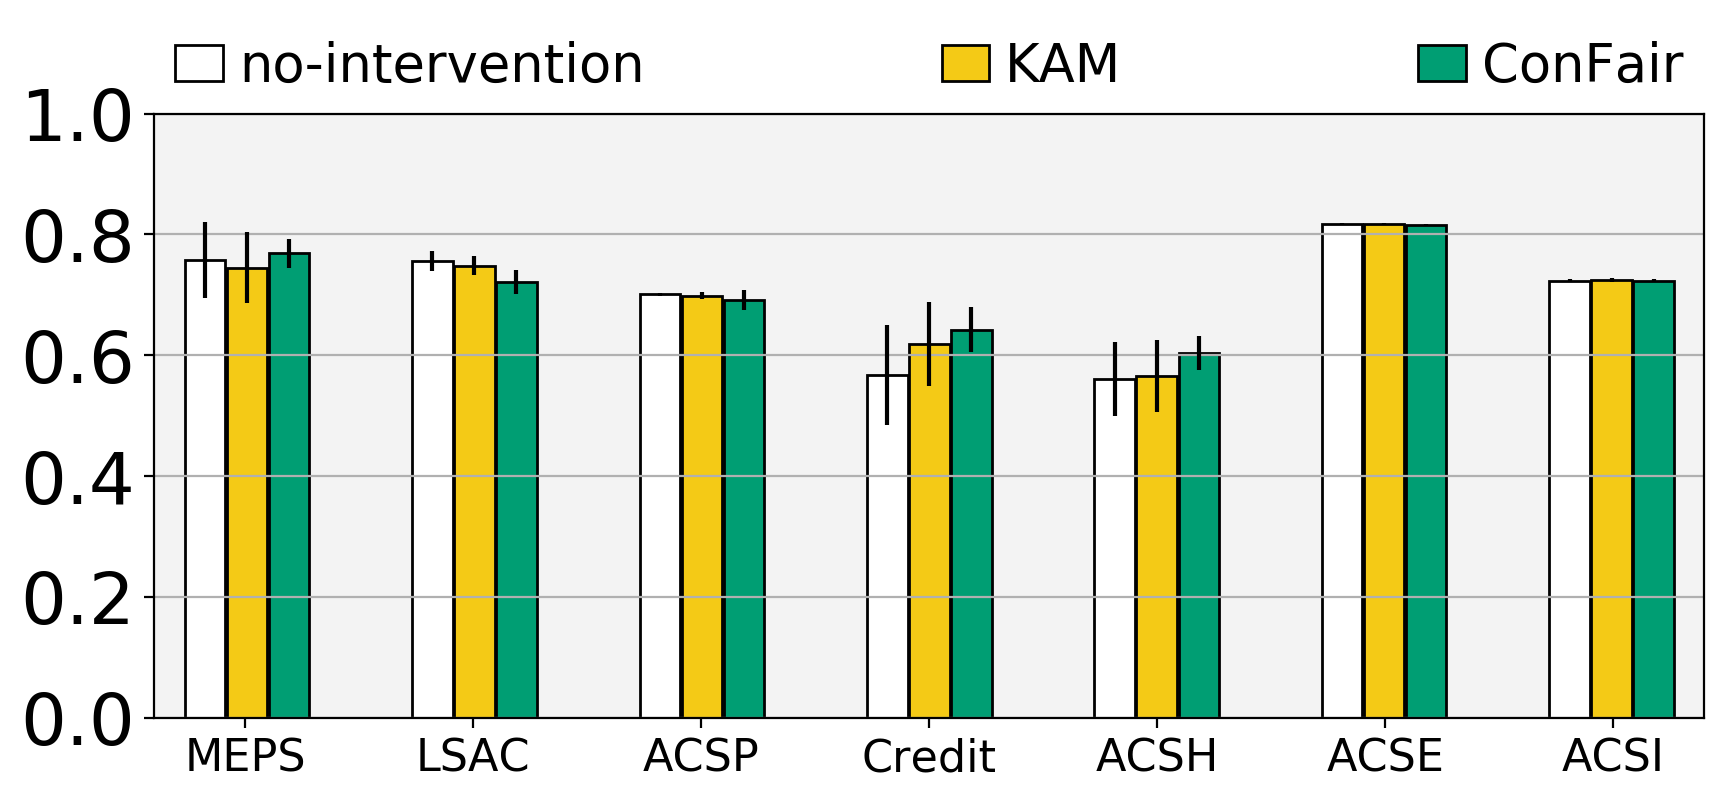

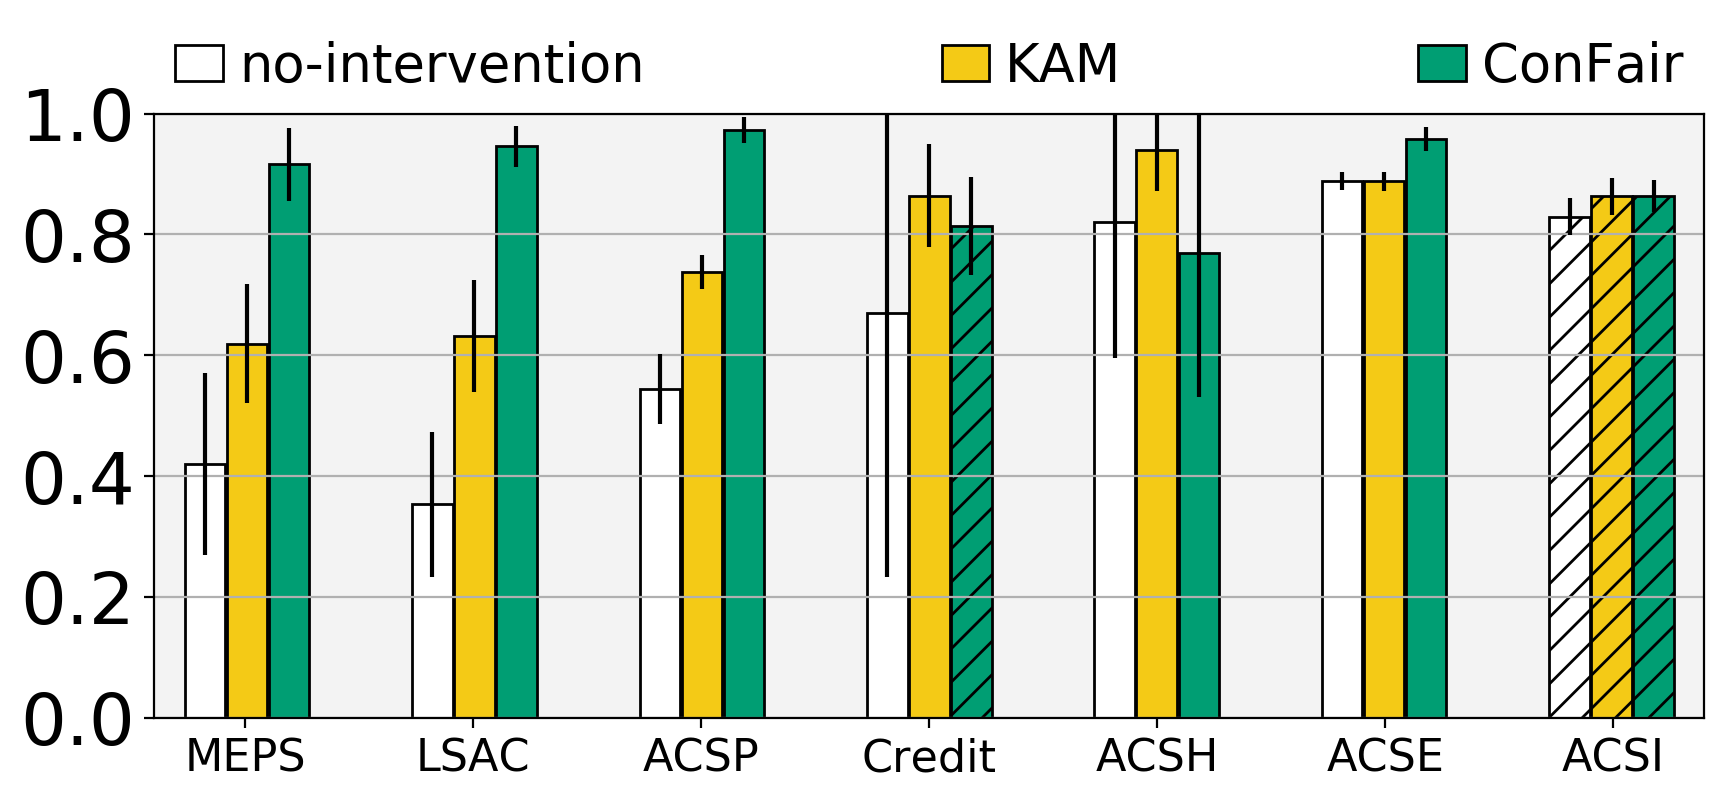

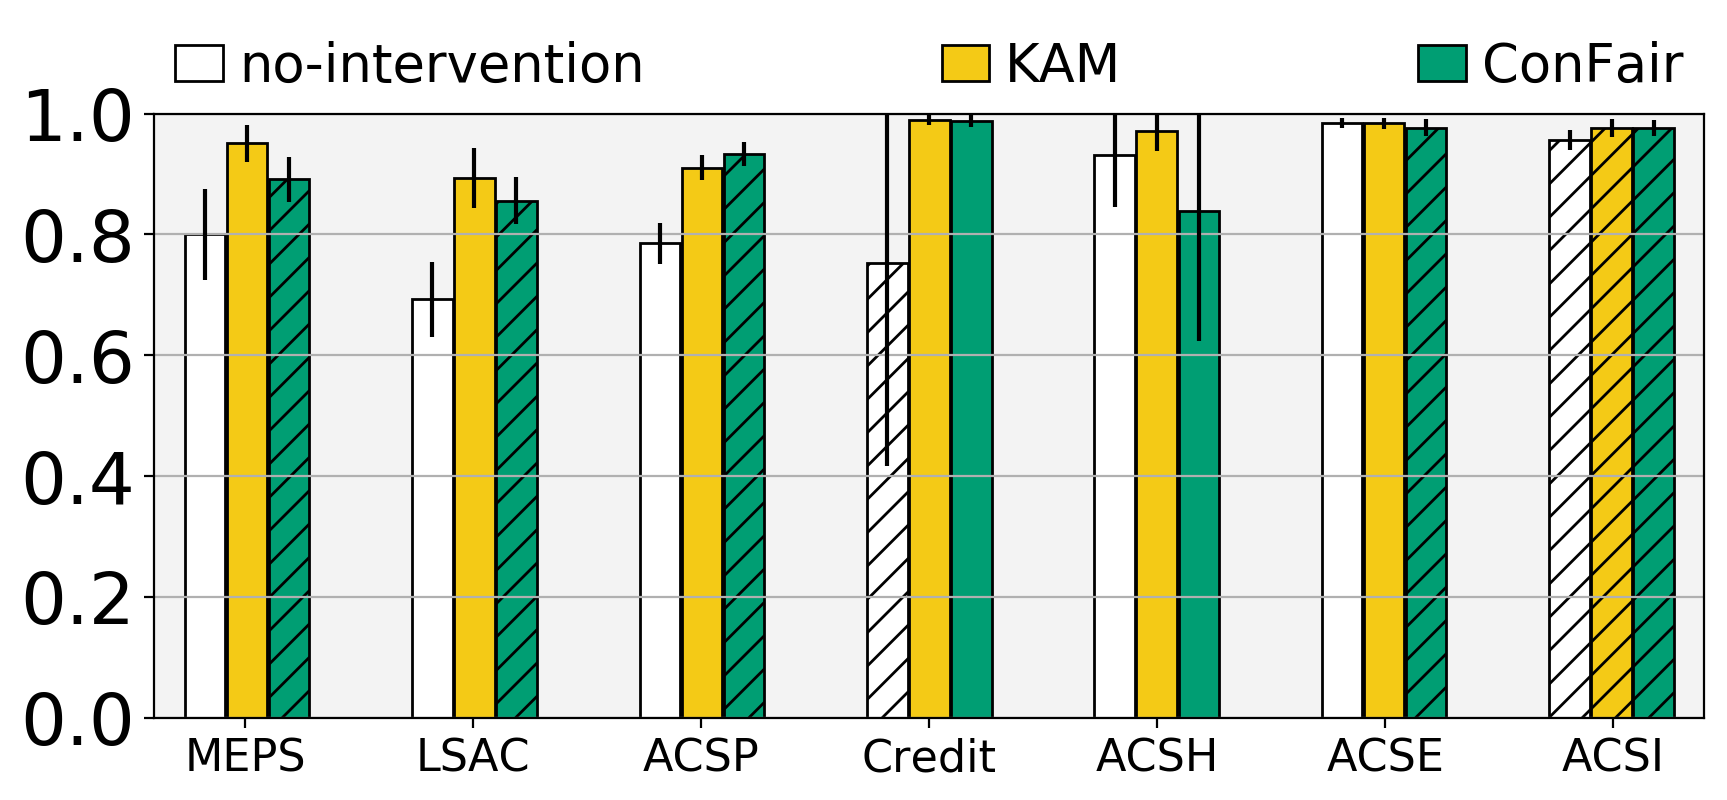

In [11]:
eval_suffix = 'ConFair-KAM'

# new order of datasets in visualization
exp_datasets = ['meps16', 'lsac', 'ACSP', 'credit', 'ACSH', 'ACSE', 'ACSI']
exp_ticks = ['MEPS', 'LSAC', 'ACSP', 'Credit', 'ACSH', 'ACSE', 'ACSI']


fair_settings = ['ORIG', 'KAM-ONE', 'SCC-KAM']
fair_legends = ['no-intervention', 'KAM', 'ConFair']

color_map = {'ORIG': {'face':'#ffffff', 'filling':'black'},
             'MCC-MIN-NOOPT': {'face':'#2b4a96', 'filling':'white'},
             'MCC-MIN': {'face':'#7ca1cc', 'filling':'black'},
             'SCC-KAM-NOOPT': {'face':'#004d38', 'filling':'white'},
             'SCC-KAM': {'face':'#009e73', 'filling':'black'},
             'SEP': {'face':'#fffacd', 'filling':'black'},
             'MCC-W2': {'face':'#7ca1cc', 'filling':'black'},
             'KAM-ONE': {'face':'#f4ca16', 'filling':'black'}
            }

eval_metrics = ['BalAcc', 'DI', 'AvgOddsDiff', 'EQDiff', 'FPRDiff', 'FNRDiff', 'ERRDiff'][:3]



x_tick_set = 4.5
for model_name in models:
        
    vis_df = eval_df.query('model=="{}"'.format(model_name))
    
    for exp_metric in eval_metrics:
        output_name = '{}{}-{}-{}.png'.format(plot_path, model_name, eval_suffix, exp_metric)
        bar_plots(vis_df, output_name, exp_datasets, exp_metric, fair_settings, group_input='all', 
                  x_ticks=exp_ticks, color_map=color_map, 
                  legend_names=fair_legends, x_tick_offset=x_tick_set,
                  legend_col=len(fair_settings),
                  save_to_disc=True)

            

## Comparing ConFair to OMN

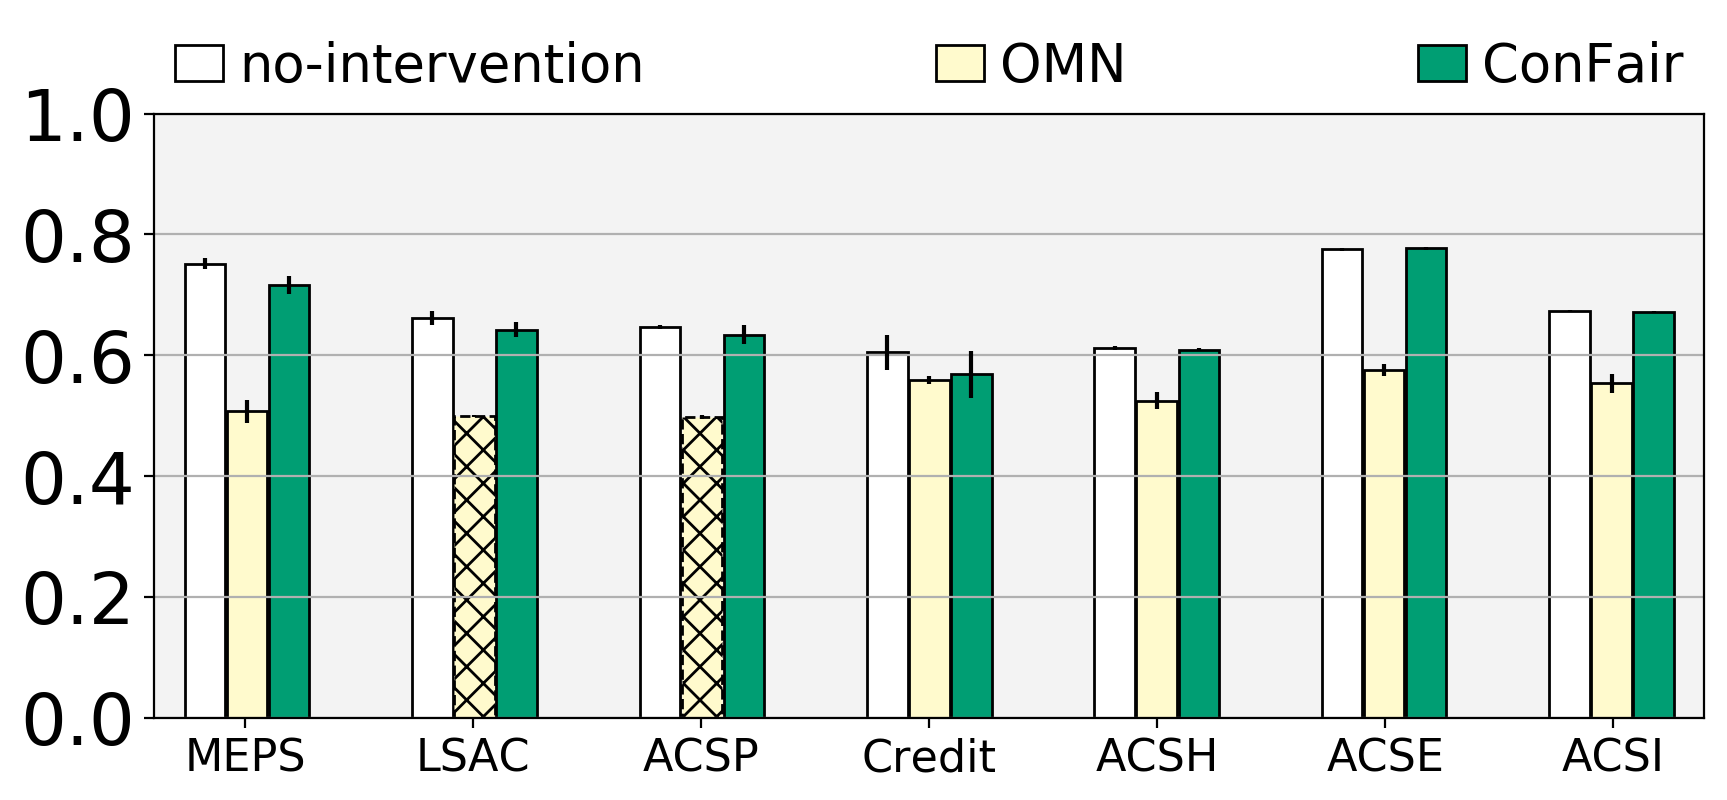

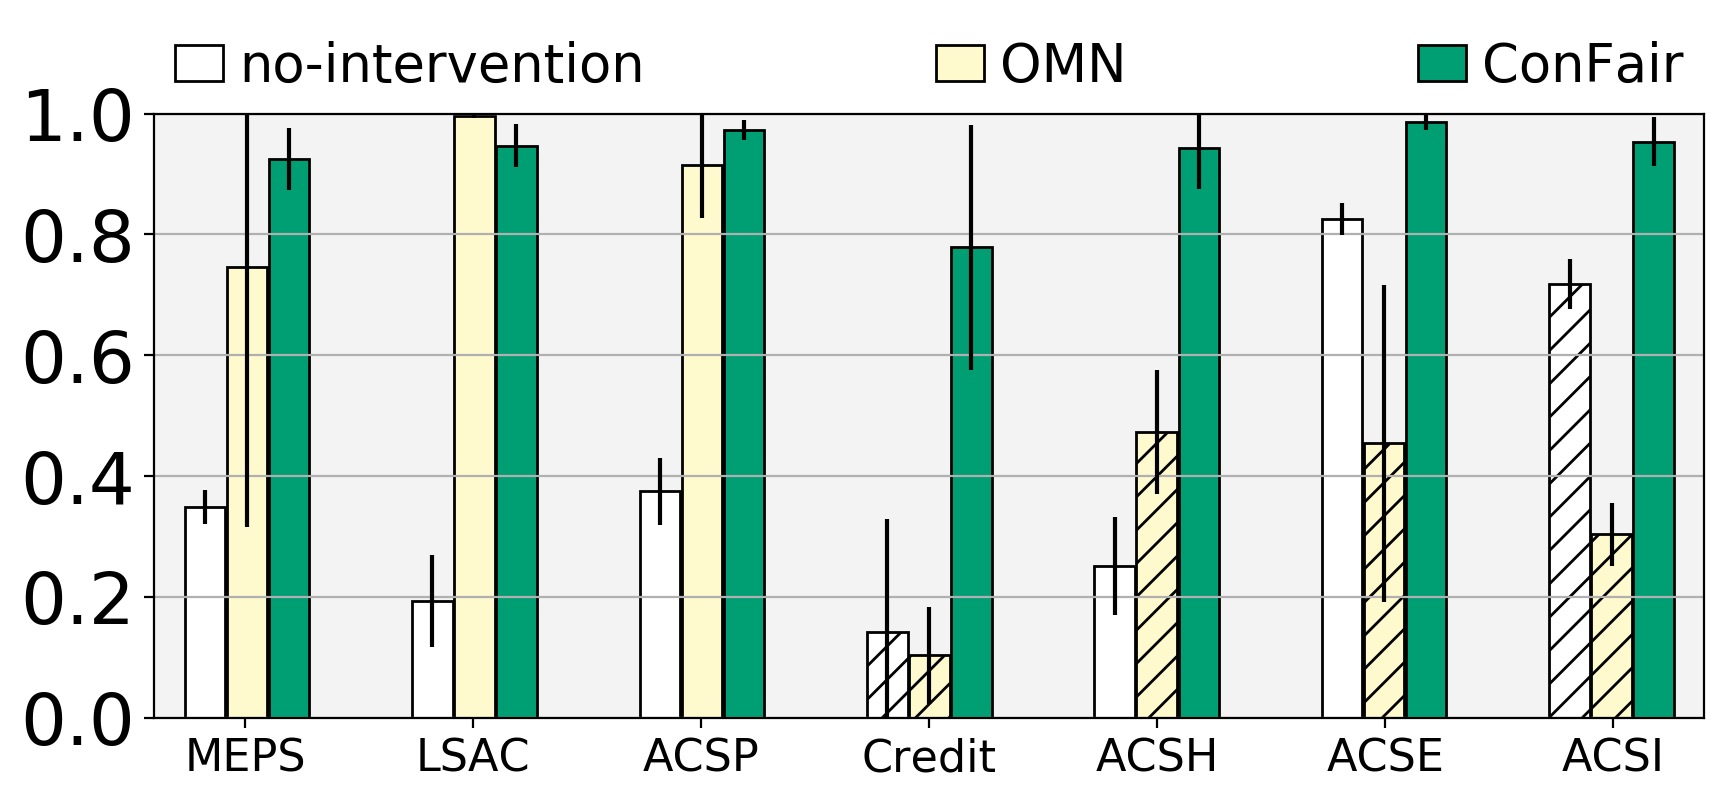

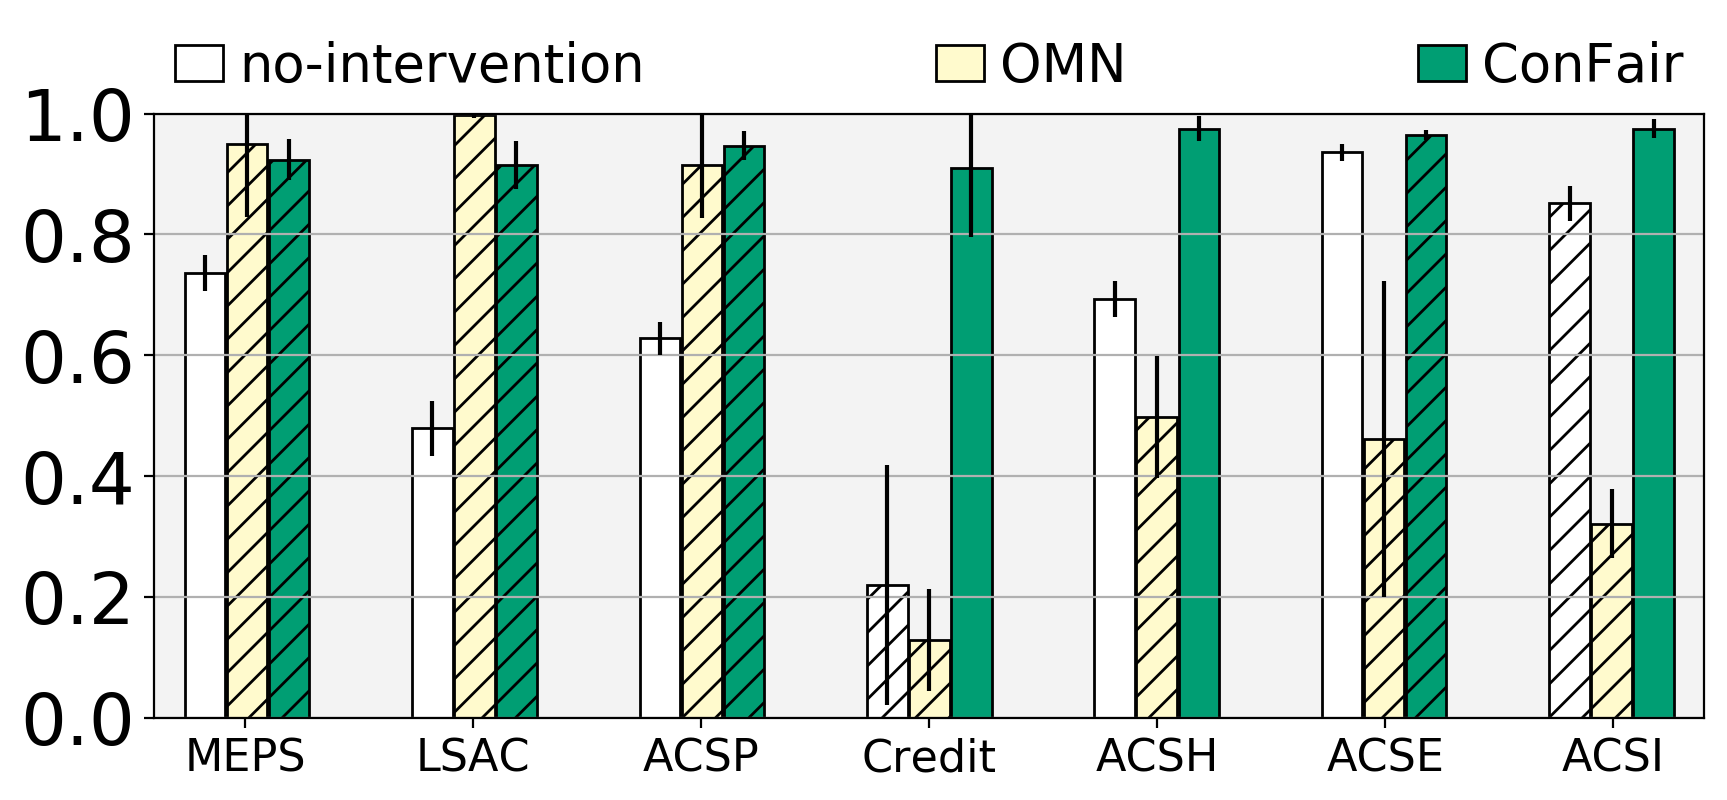

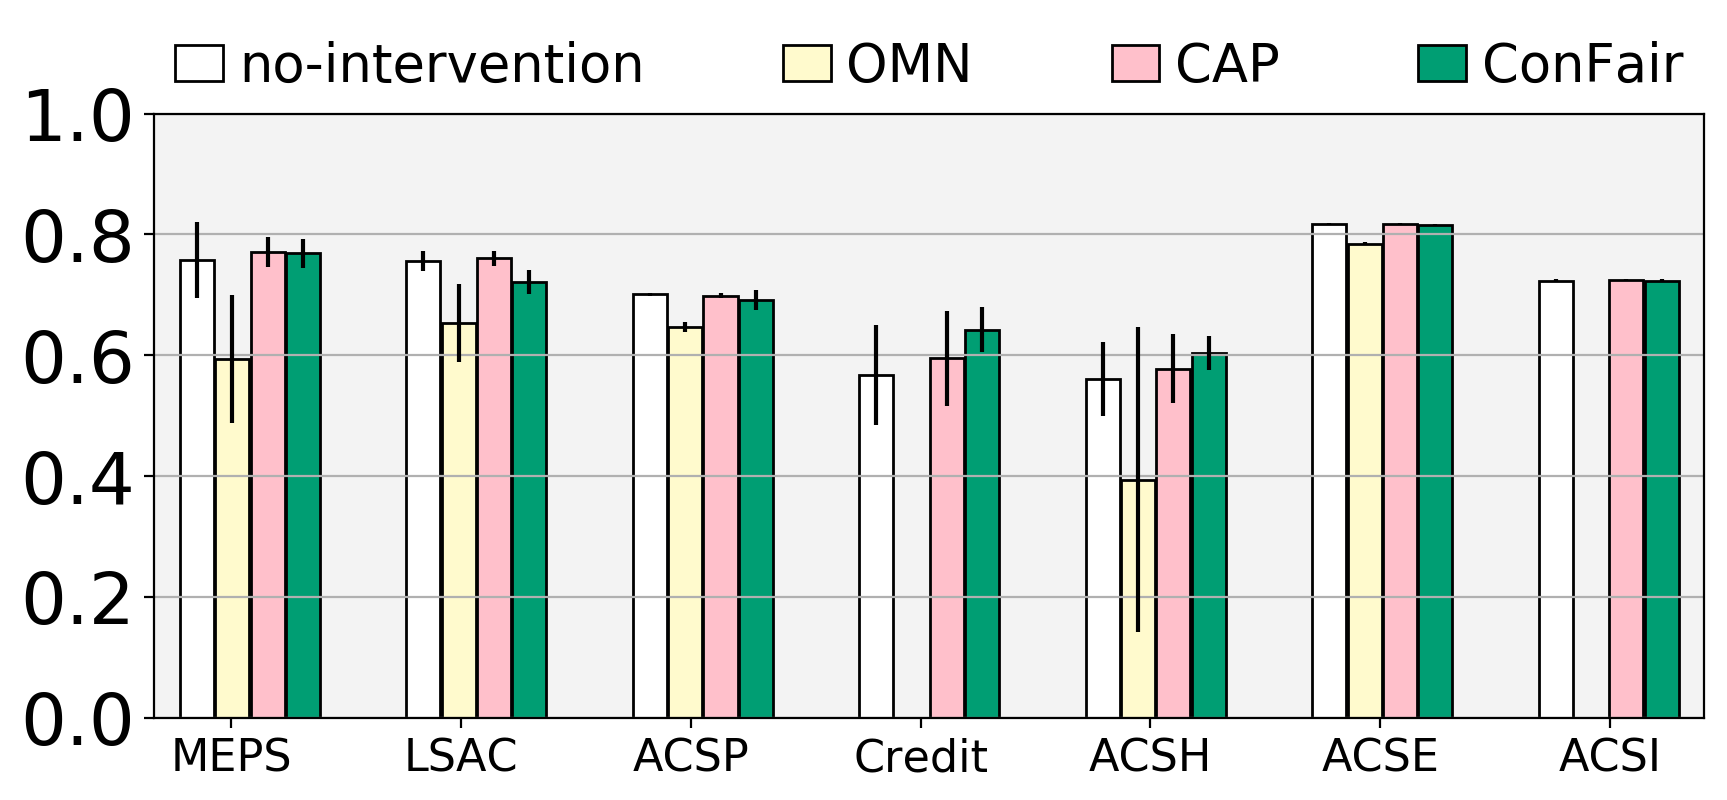

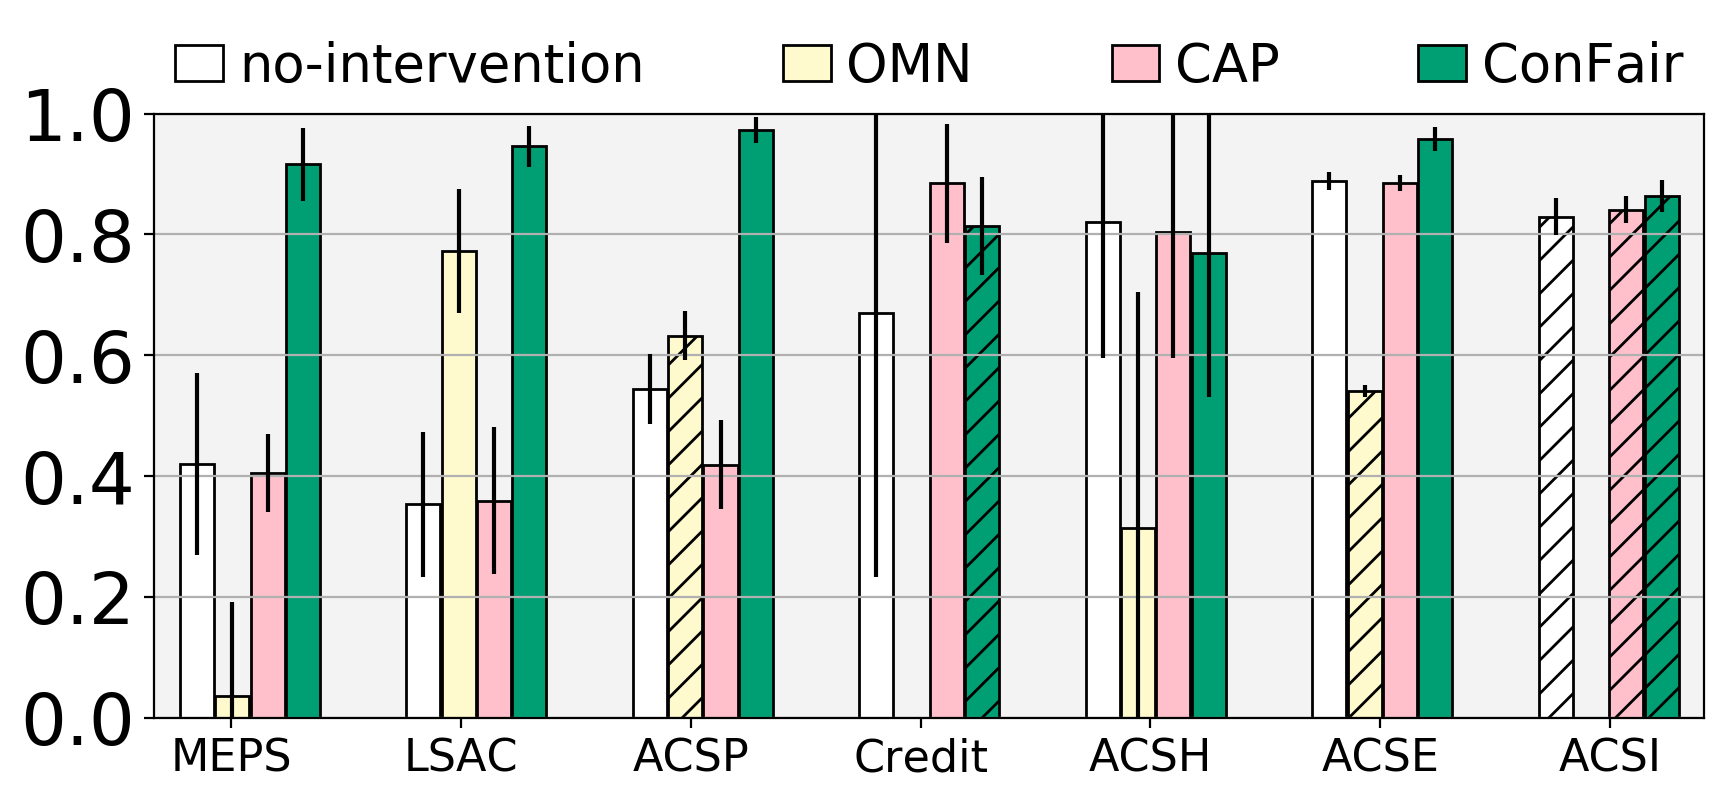

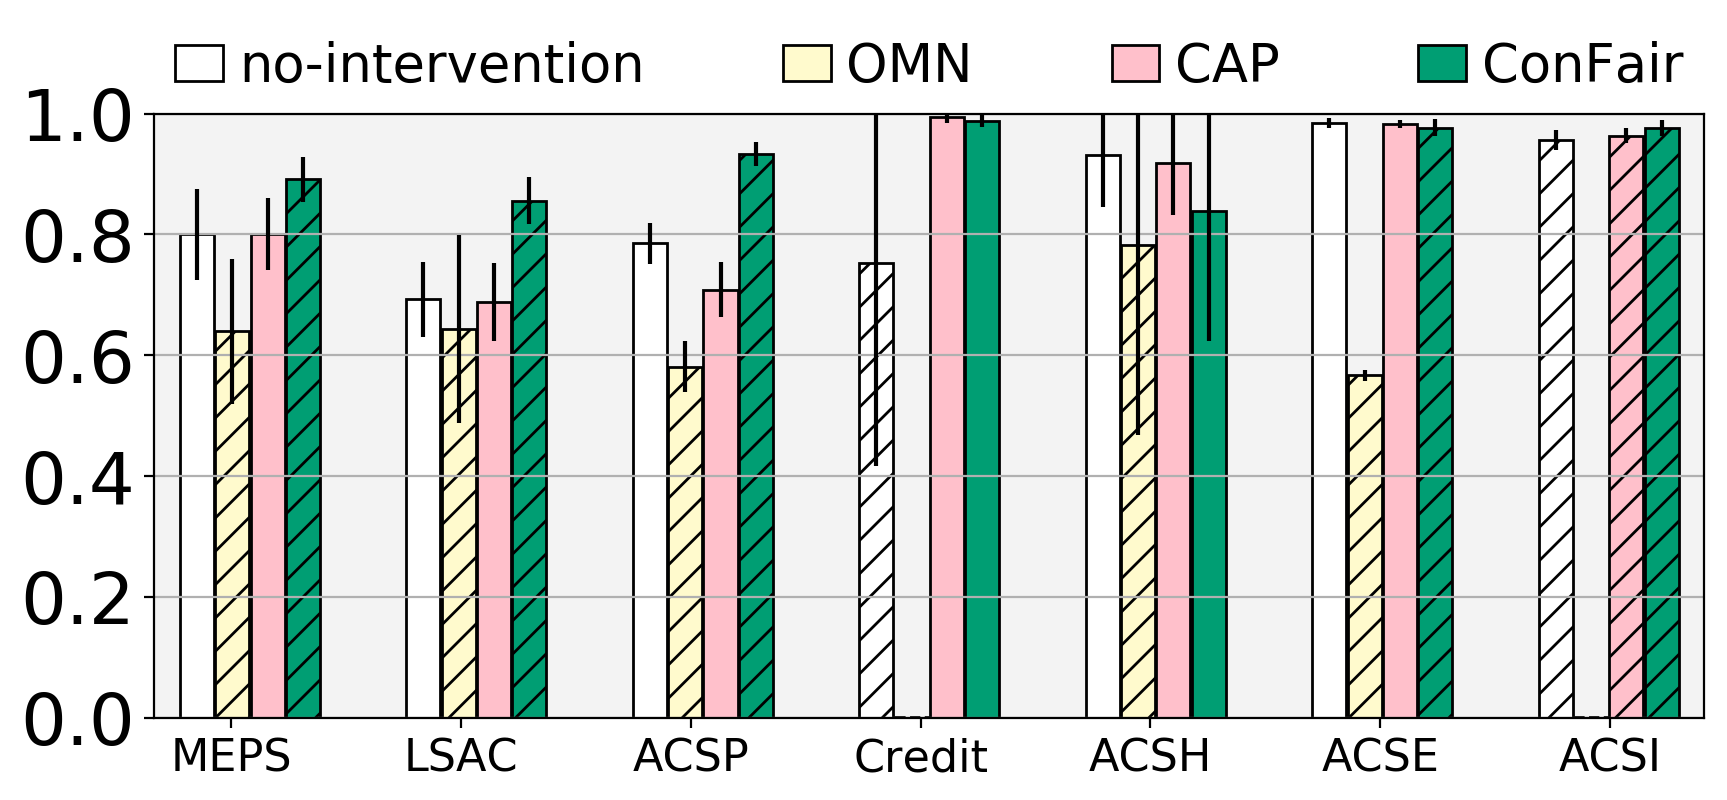

In [12]:
eval_suffix = 'ConFair-OMN'

fair_settings = ['ORIG', 'OMN-ONE', 'SCC-KAM']
fair_legends = ['no-intervention', 'OMN', 'ConFair']

color_map = {'ORIG': {'face':'#ffffff', 'filling':'black'},
             'MCC-MIN-NOOPT': {'face':'#2b4a96', 'filling':'white'},
             'MCC-MIN': {'face':'#7ca1cc', 'filling':'black'},
             'SCC-KAM-NOOPT': {'face':'#004d38', 'filling':'white'},
             'SCC-KAM': {'face':'#009e73', 'filling':'black'},
             'SEP': {'face':'#fffacd', 'filling':'black'},
             'MCC-W2': {'face':'#7ca1cc', 'filling':'black'},
             'KAM-ONE': {'face':'#f4ca16', 'filling':'black'},
             'OMN-ONE': {'face':'#fffacd', 'filling':'black'},
             'CAP-ONE': {'face':'#ffc0cb', 'filling':'black'}
            }

eval_metrics = ['BalAcc', 'DI', 'AvgOddsDiff', 'EQDiff', 'FPRDiff', 'FNRDiff', 'ERRDiff'][:3]

x_tick_set = 4.5

for model_name in models:
    if model_name == 'TR': # add CAP for XGB models
        fair_settings = ['ORIG', 'OMN-ONE', 'CAP-ONE', 'SCC-KAM']
        fair_legends = ['no-intervention', 'OMN', 'CAP', 'ConFair']
        x_tick_set = 5.4
    
    vis_df = eval_df.query('model=="{}"'.format(model_name))
    
    for exp_metric in eval_metrics:
        output_name = '{}{}-{}-{}.png'.format(plot_path, model_name, eval_suffix, exp_metric)
        bar_plots(vis_df, output_name, exp_datasets, exp_metric, fair_settings, group_input='all', 
                  x_ticks=exp_ticks, color_map=color_map, 
                  legend_names=fair_legends, x_tick_offset=x_tick_set,
                  legend_col=len(fair_settings),
                  save_to_disc=True)

            